Note: you may need to restart the kernel to use updated packages.
Dataset shape: (345407, 10)

First few rows:
                         State                  District      Crop     Year  \
0  Andaman and Nicobar Islands                  NICOBARS  Arecanut  2001-02   
1  Andaman and Nicobar Islands                  NICOBARS  Arecanut  2002-03   
2  Andaman and Nicobar Islands                  NICOBARS  Arecanut  2003-04   
3  Andaman and Nicobar Islands  NORTH AND MIDDLE ANDAMAN  Arecanut  2001-02   
4  Andaman and Nicobar Islands            SOUTH ANDAMANS  Arecanut  2002-03   

       Season    Area Area Units  Production Production Units     Yield  
0      Kharif  1254.0    Hectare      2061.0           Tonnes  1.643541  
1  Whole Year  1258.0    Hectare      2083.0           Tonnes  1.655803  
2  Whole Year  1261.0    Hectare      1525.0           Tonnes  1.209358  
3      Kharif  3100.0    Hectare      5239.0           Tonnes  1.690000  
4  Whole Year  3105.0    Hectare      5267.0

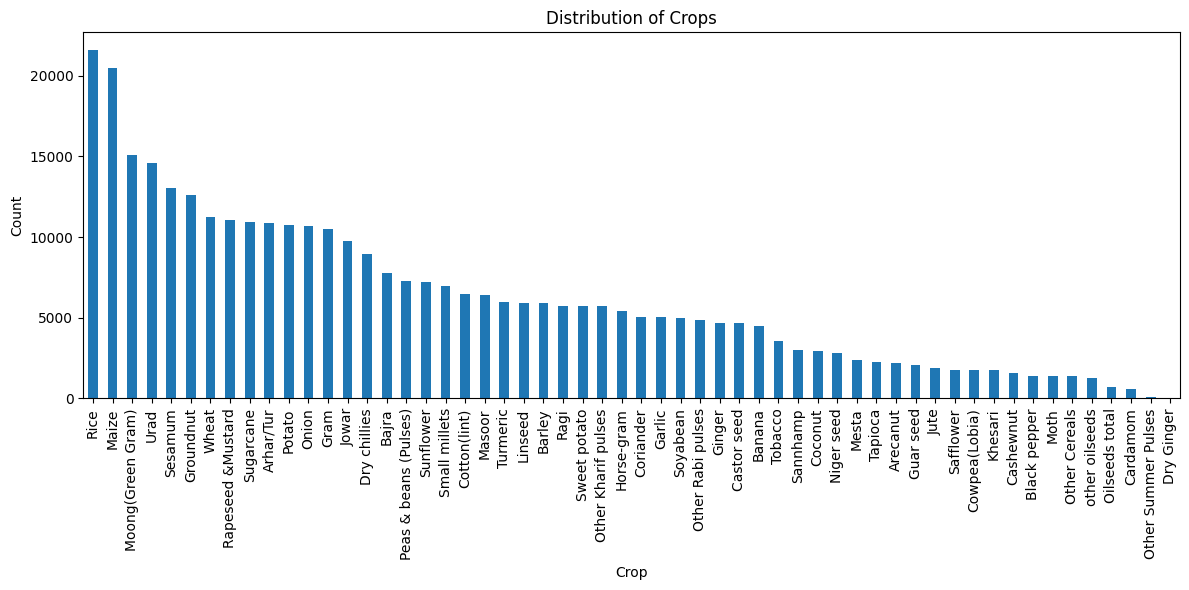

In [2]:
%pip install pandas numpy matplotlib seaborn scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv("India Agriculture Crop Production.csv")

# Initial exploration
print("Dataset shape:", data.shape)
print("\nFirst few rows:")
print(data.head())

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

# Summary statistics
print("\nSummary statistics:")
print(data.describe())

# Unique values in categorical columns
print("\nUnique values in categorical columns:")
print("States:", data['State'].nunique())
print("Districts:", data['District'].nunique())
print("Crops:", data['Crop'].nunique())
print("Seasons:", data['Season'].nunique())

# Distribution of crops
plt.figure(figsize=(12, 6))
data['Crop'].value_counts().plot(kind='bar')
plt.title('Distribution of Crops')
plt.xlabel('Crop')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

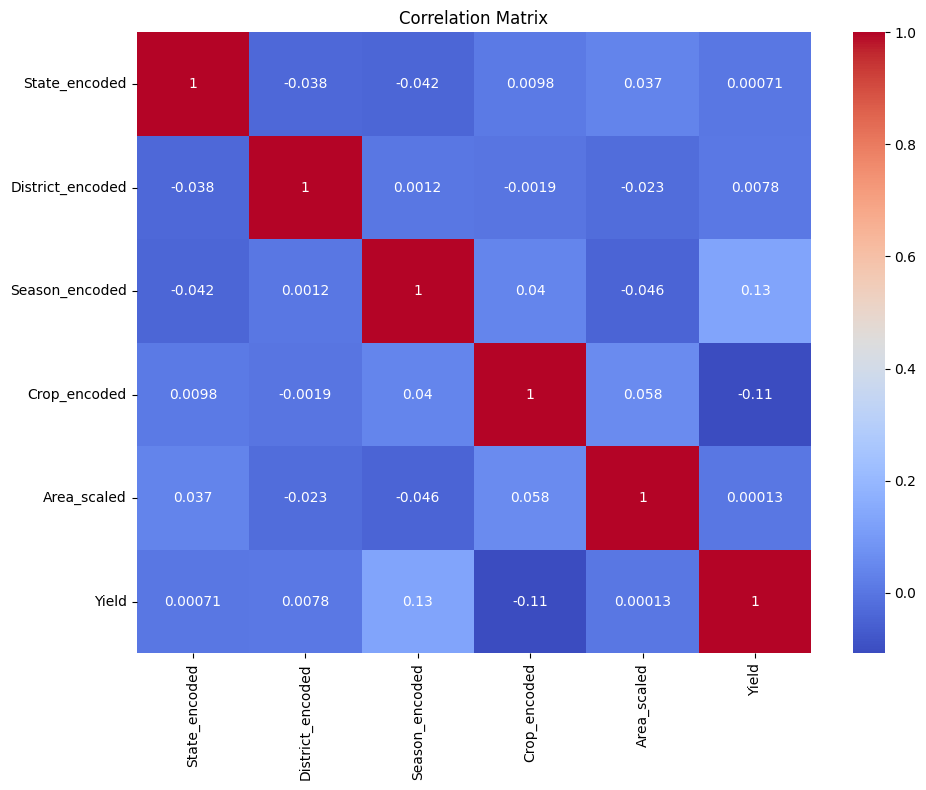

In [3]:
# Handle missing values
data = data.dropna()

# Encode categorical variables
le_state = LabelEncoder()
le_district = LabelEncoder()
le_season = LabelEncoder()
le_crop = LabelEncoder()

data['State_encoded'] = le_state.fit_transform(data['State'])
data['District_encoded'] = le_district.fit_transform(data['District'])
data['Season_encoded'] = le_season.fit_transform(data['Season'])
data['Crop_encoded'] = le_crop.fit_transform(data['Crop'])

# Create mappings for later reference
state_mapping = dict(zip(le_state.transform(le_state.classes_), le_state.classes_))
district_mapping = dict(zip(le_district.transform(le_district.classes_), le_district.classes_))
season_mapping = dict(zip(le_season.transform(le_season.classes_), le_season.classes_))
crop_mapping = dict(zip(le_crop.transform(le_crop.classes_), le_crop.classes_))

# Standardize numerical features
scaler = StandardScaler()
data['Area_scaled'] = scaler.fit_transform(data[['Area']])

# Create a new dataframe with encoded and scaled features
processed_data = data[['State_encoded', 'District_encoded', 'Season_encoded', 'Crop_encoded', 'Area_scaled', 'Yield']]

# Check correlations
plt.figure(figsize=(10, 8))
sns.heatmap(processed_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [4]:
# Add interaction terms
processed_data['State_District'] = processed_data['State_encoded'] * processed_data['District_encoded']
processed_data['State_Season'] = processed_data['State_encoded'] * processed_data['Season_encoded']
processed_data['District_Season'] = processed_data['District_encoded'] * processed_data['Season_encoded']

# Group by State, District, Season and get the average yield for each crop
avg_yield = data.groupby(['State_encoded', 'District_encoded', 'Season_encoded', 'Crop_encoded'])['Yield'].mean().reset_index()
avg_yield.rename(columns={'Yield': 'Avg_Yield'}, inplace=True)

# Merge with the processed data
processed_data = pd.merge(processed_data, avg_yield, 
                         on=['State_encoded', 'District_encoded', 'Season_encoded', 'Crop_encoded'], 
                         how='left')

# Fill missing values with overall average yield
processed_data['Avg_Yield'].fillna(processed_data['Yield'].mean(), inplace=True)

# Split the data into features and target
X = processed_data[['State_encoded', 'District_encoded', 'Season_encoded', 'Crop_encoded', 
                    'Area_scaled', 'State_District', 'State_Season', 'District_Season', 'Avg_Yield']]
y = processed_data['Yield']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Training multiple models to compare
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {'MSE': mse, 'R2': r2}
    
    print(f"\n{name} Results:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R² Score: {r2:.4f}")

# Find the best model
best_model_name = max(results, key=lambda x: results[x]['R2'])
print(f"\nBest Model: {best_model_name}")
print(f"R² Score: {results[best_model_name]['R2']:.4f}")
best_model = models[best_model_name]


Random Forest Results:
Mean Squared Error: 97969.45
R² Score: 0.8782

Gradient Boosting Results:
Mean Squared Error: 89680.08
R² Score: 0.8885

Best Model: Gradient Boosting
R² Score: 0.8885


In [6]:
# Hyperparameter tuning for the best model
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
else:  # Gradient Boosting
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }

# Use RandomizedSearchCV instead of GridSearchCV for faster results
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=best_model,
    param_distributions=param_grid,
    n_iter=5,
    cv=3,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
print(f"Best Parameters: {random_search.best_params_}")
tuned_model = random_search.best_estimator_

# Evaluate the tuned model
y_pred_tuned = tuned_model.predict(X_test)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f"\nTuned {best_model_name} Results:")
print(f"Mean Squared Error: {mse_tuned:.2f}")
print(f"R² Score: {r2_tuned:.4f}")

Best Parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}

Tuned Gradient Boosting Results:
Mean Squared Error: 88953.64
R² Score: 0.8894


In [14]:
def recommend_crops(state_name, district_name, season_name, area, top_n=5):
    """
    Recommend top N crops based on predicted yield.
    
    Parameters:
    state_name (str): Name of the state
    district_name (str): Name of the district
    season_name (str): Name of the season
    area (float): Area in hectares
    top_n (int): Number of top crops to recommend
    
    Returns:
    DataFrame: Top N recommended crops with predicted yields
    """
    try:
        # Encode the inputs
        state_encoded = le_state.transform([state_name])[0]
        district_encoded = le_district.transform([district_name])[0]
        season_encoded = le_season.transform([season_name])[0]
        area_scaled = scaler.transform([[area]])[0][0]
        
        # Get all unique crops
        crops = le_crop.transform(le_crop.classes_)
        
        # Create a DataFrame for all crops
        input_data = pd.DataFrame()
        
        for crop in crops:
            # Calculate interaction terms
            state_district = state_encoded * district_encoded
            state_season = state_encoded * season_encoded
            district_season = district_encoded * season_encoded
            
            # Get average yield for this combination
            avg_yield_value = processed_data[
                (processed_data['State_encoded'] == state_encoded) &
                (processed_data['District_encoded'] == district_encoded) &
                (processed_data['Season_encoded'] == season_encoded) &
                (processed_data['Crop_encoded'] == crop)
            ]['Avg_Yield'].mean()
            
            # If no data exists, use the overall average
            if np.isnan(avg_yield_value):
                avg_yield_value = processed_data['Avg_Yield'].mean()
            
            # Create a row for this crop
            row = pd.DataFrame({
                'State_encoded': [state_encoded],
                'District_encoded': [district_encoded],
                'Season_encoded': [season_encoded],
                'Crop_encoded': [crop],
                'Area_scaled': [area_scaled],
                'State_District': [state_district],
                'State_Season': [state_season],
                'District_Season': [district_season],
                'Avg_Yield': [avg_yield_value]
            })
            
            input_data = pd.concat([input_data, row], ignore_index=True)
        
        # Predict yields for all crops
        input_data['Predicted_Yield'] = tuned_model.predict(input_data[X.columns])
        
        # Add actual crop names
        input_data['Crop'] = le_crop.inverse_transform(input_data['Crop_encoded'])
        
        # Sort by predicted yield and return top N crops
        recommendations = input_data.sort_values(by='Predicted_Yield', ascending=False).head(top_n)
        return recommendations[['Crop', 'Predicted_Yield']]
    
    except KeyError as e:
        print(f"Error: {e}. Please check if the state, district, or season exists in the dataset.")
        return pd.DataFrame()

# Example usage
state_name = "Telangana"
district_name = "ADILABAD"
season_name = "Kharif"  # Change to a season that exists in your dataset
area = 34.0

recommendations = recommend_crops(state_name, district_name, season_name, area, top_n=5)
print(f"\nTop 5 Recommended Crops for {state_name}, {district_name}, {season_name} Season:")
for index, row in recommendations.iterrows():
    print(f"{row['Crop']}: {row['Predicted_Yield']:.2f} tonnes/hectare")


Top 5 Recommended Crops for Telangana, ADILABAD, Kharif Season:
Arecanut: 79.13 tonnes/hectare
Jute: 79.13 tonnes/hectare
Linseed: 79.13 tonnes/hectare
Masoor: 79.13 tonnes/hectare
Mesta: 79.13 tonnes/hectare


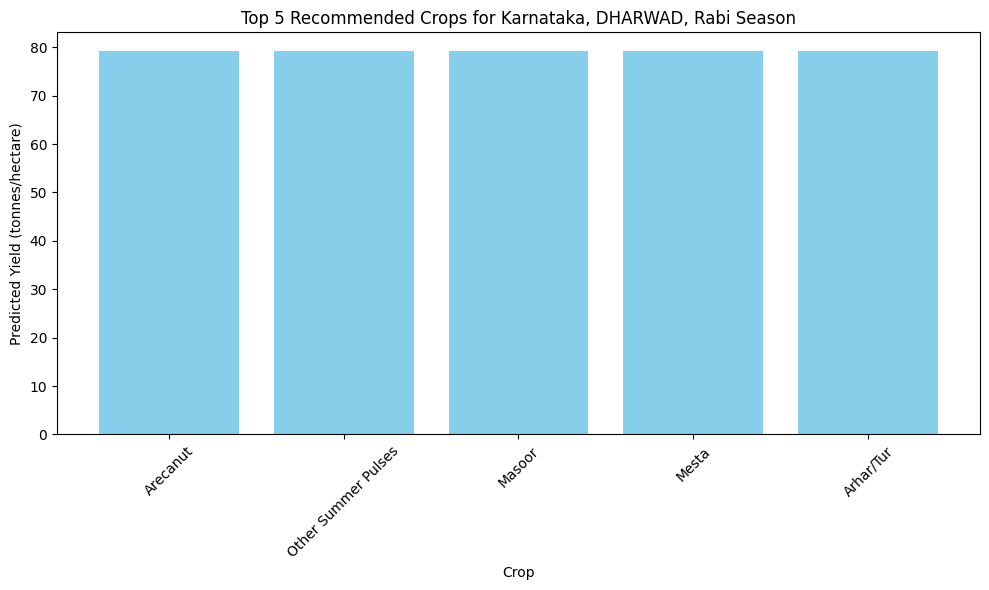

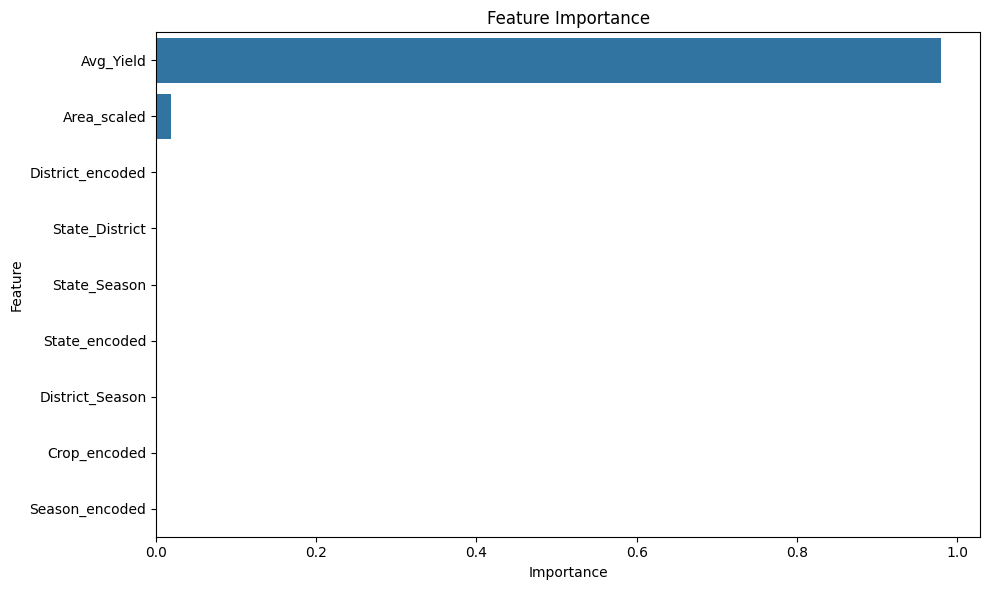

In [10]:
# Visualize top recommended crops
plt.figure(figsize=(10, 6))
plt.bar(recommendations['Crop'], recommendations['Predicted_Yield'], color='skyblue')
plt.xlabel('Crop')
plt.ylabel('Predicted Yield (tonnes/hectare)')
plt.title(f'Top 5 Recommended Crops for {state_name}, {district_name}, {season_name} Season')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check feature importance
if hasattr(tuned_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': tuned_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

In [11]:
import joblib
import os

# Save the model and preprocessing objects
model_artifacts = {
    'model': tuned_model,
    'le_state': le_state,
    'le_district': le_district,
    'le_season': le_season,
    'le_crop': le_crop,
    'scaler': scaler,
    'state_mapping': state_mapping,
    'district_mapping': district_mapping,
    'season_mapping': season_mapping,
    'crop_mapping': crop_mapping
}

# Set path to your project directory resources folder
target_path = '/Users/vvmohith/Desktop/OOAD-proj/smart-crop-advisor/src/main/resources/model/crop_recommendation_model.pkl'

# Make sure the directory exists
os.makedirs(os.path.dirname(target_path), exist_ok=True)

# Save the model
joblib.dump(model_artifacts, target_path)
print(f"Model saved to: {target_path}")

Model saved to: /Users/vvmohith/Desktop/OOAD-proj/smart-crop-advisor/src/main/resources/model/crop_recommendation_model.pkl
